# RFS - Regression

so far, just imported from experimental, so it needs cleaning up - K

## PCA

In [4]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error

'''''

X_df = pd.read_csv("x_regression.csv")
y_df = pd.read_csv("y_regression.csv")

'''''


df = pd.read_excel('TrainDataset2024.xls')

df_cleaned = df.replace(999, np.nan)

train_data_rfs = df_cleaned.drop(['ID', 'pCR (outcome)'], axis=1)

# Knn data imputation
knn_imputer = KNNImputer(n_neighbors=5)
data_imputed_knn = knn_imputer.fit_transform(train_data_rfs)

data_imputed_knn_df = pd.DataFrame(data_imputed_knn, columns=train_data_rfs.columns)

X_rfs = data_imputed_knn_df.drop(columns=['RelapseFreeSurvival (outcome)'], axis=1)
y_rfs = data_imputed_knn_df['RelapseFreeSurvival (outcome)']


categorical_vars = X_rfs.columns[(X_rfs.nunique() > 2) & (X_rfs.nunique() <= 5)]

# One-hot encode the categorical variables
X_rfs_encoded = pd.get_dummies(X_rfs, columns=categorical_vars, drop_first=True)

continuous_vars = X_rfs_encoded.columns[X_rfs_encoded.nunique() > 5]
categorical_vars = X_rfs_encoded.columns[X_rfs_encoded.nunique() <= 5]

# Apply StandardScaler only to continuous variables
scaler = StandardScaler()
X_continuous_scaled = scaler.fit_transform(X_rfs_encoded[continuous_vars])

# Convert the scaled continuous variables back to a DataFrame
X_continuous_scaled_df = pd.DataFrame(X_continuous_scaled, columns=continuous_vars)

# Combine scaled continuous variables and categorical variables back into a single DataFrame
X_scaled = pd.concat([X_continuous_scaled_df, X_rfs_encoded[categorical_vars].reset_index(drop=True)], axis=1)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_rfs, test_size=0.2, random_state=42)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=0.95)  

# Fit and transform the training data
X_train_pca = pca.fit_transform(X_train)

# Transform the test data
X_test_pca = pca.transform(X_test)

# Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Number of components:", pca.n_components_)


Explained variance ratio: [0.30235678 0.14801583 0.12866134 0.10324651 0.06056028 0.0484148
 0.02794454 0.02156861 0.02011728 0.01305745 0.01193712 0.0107857
 0.01044484 0.00898884 0.00808184 0.00782738 0.00717842 0.00568904
 0.00525955]
Number of components: 19


In [6]:
# Train a classifier (e.g., Random Forest)
clf = RandomForestRegressor(random_state=42)
clf.fit(X_train_pca, y_train)

# Make predictions
y_pred = clf.predict(X_test_pca)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print("Model accuracy after PCA:", mae)


Model accuracy after PCA: 22.59928125


In [1]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.base import TransformerMixin

class DataFrameTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.DataFrame(X, columns=self.columns)
    

df = pd.read_excel('TrainDataset2024.xls')

df_cleaned = df.replace(999, np.nan)
    
# Count missing values
missing_values = df_cleaned.isna().sum()

# columns with missing values
df_cleaned.columns[(df_cleaned.isna().sum()>0)]

train_data_rfs = df_cleaned.drop(['ID', 'pCR (outcome)'], axis=1)
X_rfs = train_data_rfs.drop(columns=['RelapseFreeSurvival (outcome)'], axis=1)
y_rfs = train_data_rfs['RelapseFreeSurvival (outcome)']

categorical_vars = X_rfs.columns[(X_rfs.nunique() > 2) & (X_rfs.nunique() <= 5)]

# One-hot encode the categorical variables
X_rfs_encoded = pd.get_dummies(X_rfs, columns=categorical_vars, drop_first=True)

# Identify continuous and categorical variables
continuous_vars = X_rfs_encoded.columns[X_rfs_encoded.nunique() > 5]
categorical_vars = X_rfs_encoded.columns[X_rfs_encoded.nunique() <= 5]

preprocessor = Pipeline([
    ('imputer', KNNImputer(n_neighbors=2)),  # Step 1: Impute missing values
    ('to_dataframe', DataFrameTransformer(columns=X_rfs_encoded.columns)),
    ('scaler', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), continuous_vars),  # Scale continuous variables
            ('cat', 'passthrough', categorical_vars)  # Use already one-hot encoded variables
        ]
    ))
])


# Define different regressors
regressors = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf'),
    'KNeighbors': KNeighborsRegressor(n_neighbors=5),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'MLPRegressor': MLPRegressor(hidden_layer_sizes=(100,), activation='relu', max_iter=500, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

# Create pipelines for each regressor
pipelines = {name: Pipeline([('preprocessor', preprocessor), ('regressor', reg)]) for name, reg in regressors.items()}

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_rfs_encoded, y_rfs, test_size=0.2, random_state=42)

# Define a custom scoring metric (Mean Absolute Error in this case)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

results = {}

for name, pipeline in pipelines.items():
        
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(pipeline, X_rfs_encoded, y_rfs, cv=5, scoring=mae_scorer)
    cv_scores = -cv_scores  # Convert scores to positive

    results[name] = {
        'cv_scores': cv_scores,
        'cv_mean_mae': cv_scores.mean(),
        'cv_std_mae': cv_scores.std()
    }
    
    print(f"Model: {name}")
    print(f"Cross-Validation MAE Scores: {cv_scores}")
    print(f"Mean CV MAE: {cv_scores.mean():.4f}")
    print(f"Standard Deviation of CV MAE: {cv_scores.std():.4f}")
    print()



Model: LinearRegression
Cross-Validation MAE Scores: [ 46.58162636 255.5321046  142.88136004  26.39078387  28.37198897]
Mean CV MAE: 99.9516
Standard Deviation of CV MAE: 88.8048

Model: RandomForest
Cross-Validation MAE Scores: [42.35838542 20.64008333 13.39829167 22.25151042 14.47441667]
Mean CV MAE: 22.6245
Standard Deviation of CV MAE: 10.4408

Model: GradientBoosting
Cross-Validation MAE Scores: [41.42758391 20.44063414 15.21258255 22.47574634 16.48885651]
Mean CV MAE: 23.2091
Standard Deviation of CV MAE: 9.4786

Model: AdaBoost
Cross-Validation MAE Scores: [41.521875 22.5375   15.19375  23.628125 16.740625]
Mean CV MAE: 23.9244
Standard Deviation of CV MAE: 9.3756

Model: SVR
Cross-Validation MAE Scores: [43.00675994 22.46846099 11.91787958 24.0879602  14.69016961]
Mean CV MAE: 23.2342
Standard Deviation of CV MAE: 10.8934

Model: KNeighbors
Cross-Validation MAE Scores: [44.655      23.41020833 16.07229167 23.58125    16.221875  ]
Mean CV MAE: 24.7881
Standard Deviation of CV MA

/Applications/Anaconda/anaconda3/envs/MLE/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/Anaconda/anaconda3/envs/MLE/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/Anaconda/anaconda3/envs/MLE/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/Anaconda/anaconda3/envs/MLE/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization

Model: MLPRegressor
Cross-Validation MAE Scores: [40.87252057 20.82423273 21.71636377 20.6240145  20.35549927]
Mean CV MAE: 24.8785
Standard Deviation of CV MAE: 8.0100

Model: XGBoost
Cross-Validation MAE Scores: [41.41642199 19.14367373 14.62534261 22.86145215 16.91738142]
Mean CV MAE: 22.9929
Standard Deviation of CV MAE: 9.6040



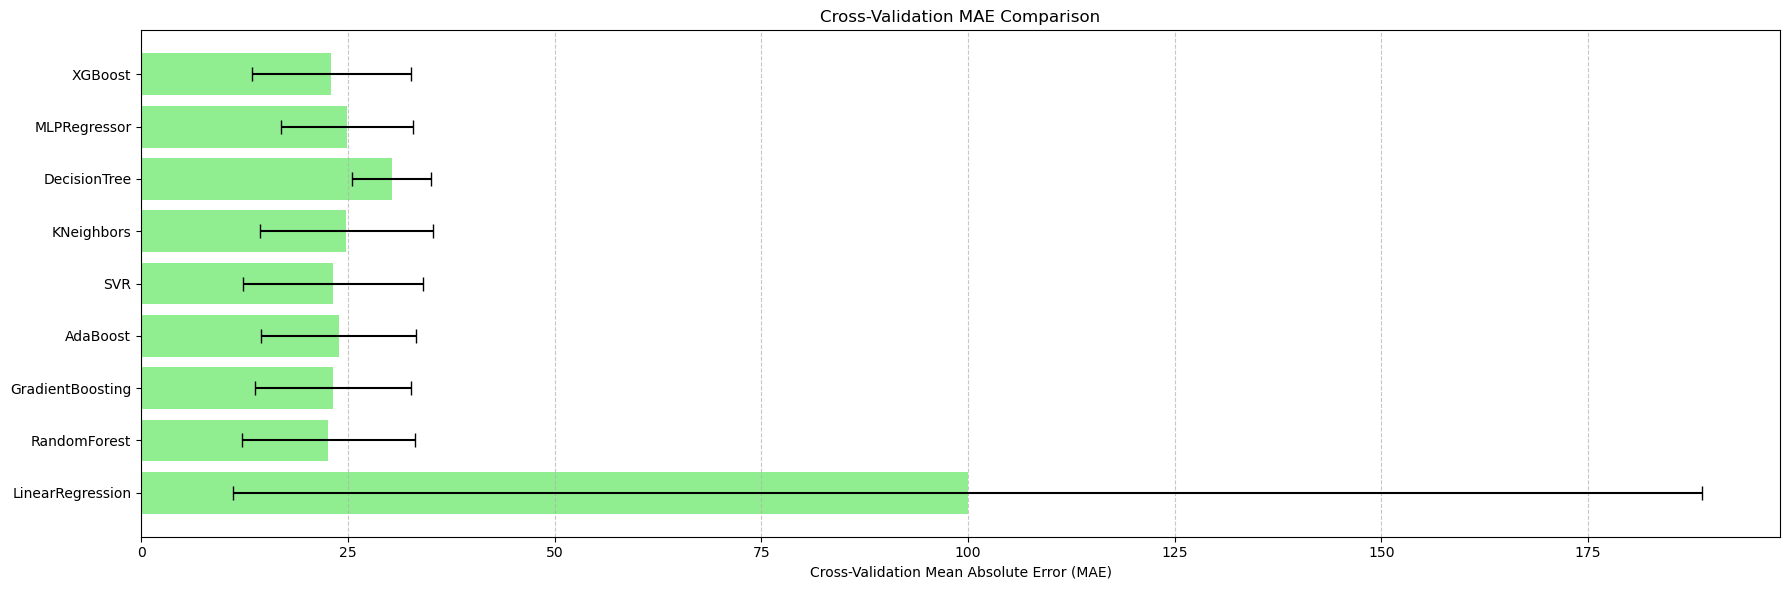

In [2]:
# Extract model names and their corresponding metrics
model_names = list(results.keys())
cv_mean_mae = [results[name]['cv_mean_mae'] for name in model_names]
cv_std_mae = [results[name]['cv_std_mae'] for name in model_names]

# Create bar plots for MAE, MSE, and CV MAE
plt.figure(figsize=(18, 6))

# Cross-Validation MAE Plot
plt.subplot(1, 1, 1)
plt.barh(model_names, cv_mean_mae, xerr=cv_std_mae, color='lightgreen', capsize=5)
plt.xlabel('Cross-Validation Mean Absolute Error (MAE)')
plt.title('Cross-Validation MAE Comparison')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()
